In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import joblib

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc, roc_curve
)

print("Libraries imported.")

# Detect Environment
running_in_colab = "COLAB_GPU" in os.environ
if running_in_colab:
    BASE = Path("/content/data")
    if not BASE.exists():
        BASE = Path("/content")
else:
    current_dir = Path.cwd()

    if (current_dir.parent / "data").exists():
        BASE = current_dir.parent / "data"      # notebook is inside /notebooks/
    elif (current_dir / "data").exists():
        BASE = current_dir / "data"
    else:
        BASE = current_dir

print("Using BASE directory:", BASE)

# Correct model path — NO slash, NO content/, NO (4)
model_path = BASE / "trained_models_and_test_data.pkl"
print("Loading artifacts from:", model_path)

# Load
artifacts = joblib.load(model_path)

# Unpack dictionary
rf_model      = artifacts.get("rf_model")
lr_model      = artifacts.get("lr_model")
gb_model      = artifacts.get("gb_model")
best_model    = artifacts.get("best_model", rf_model)
X_test        = artifacts["X_test"]
y_test        = artifacts["y_test"]
scaler        = artifacts["scaler"]
feature_names = artifacts["feature_names"]

print("Models and test data loaded successfully.")
print("Available artifact keys:", artifacts.keys())


Libraries imported.
Using BASE directory: D:\fraud_detection_project\data
Loading artifacts from: D:\fraud_detection_project\data\trained_models_and_test_data.pkl
Models and test data loaded successfully.
Available artifact keys: dict_keys(['rf_model', 'lr_model', 'gb_model', 'best_model', 'X_test', 'y_test', 'scaler', 'feature_names'])


In [2]:
def get_metrics(model, X, y, name):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    report = classification_report(y, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y, y_prob)
    precision, recall, _ = precision_recall_curve(y, y_prob)
    pr_auc = auc(recall, precision)

    return {
        "Model": name,
        "Precision (Fraud)": report['1']['precision'],
        "Recall (Fraud)": report['1']['recall'],
        "F1-Score (Fraud)": report['1']['f1-score'],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    }

metrics_list = []
metrics_list.append(get_metrics(rf_model, X_test, y_test, "Random Forest"))
metrics_list.append(get_metrics(lr_model, X_test, y_test, "Logistic Regression"))
metrics_list.append(get_metrics(gb_model, X_test, y_test, "Gradient Boosting"))

# If best_model is distinct, evaluate it as well
if best_model is not None and best_model is not rf_model and best_model is not gb_model and best_model is not lr_model:
    metrics_list.append(get_metrics(best_model, X_test, y_test, "Best Model (from tuning)"))

metrics_df = pd.DataFrame(metrics_list)
print("\n--- Model Performance Comparison (Test Set) ---")
display(metrics_df)


--- Model Performance Comparison (Test Set) ---


,Model,Precision (Fraud),Recall (Fraud),F1-Score (Fraud),ROC-AUC,PR-AUC
0,Random Forest,0.581395,0.742574,0.652174,0.941987,0.694782
1,Logistic Regression,0.481481,0.900990,0.627586,0.956409,0.763430
2,Gradient Boosting,0.509317,0.811881,0.625954,0.947159,0.717192
3,Best Model (from tuning),0.555556,0.742574,0.635593,0.943132,0.710088


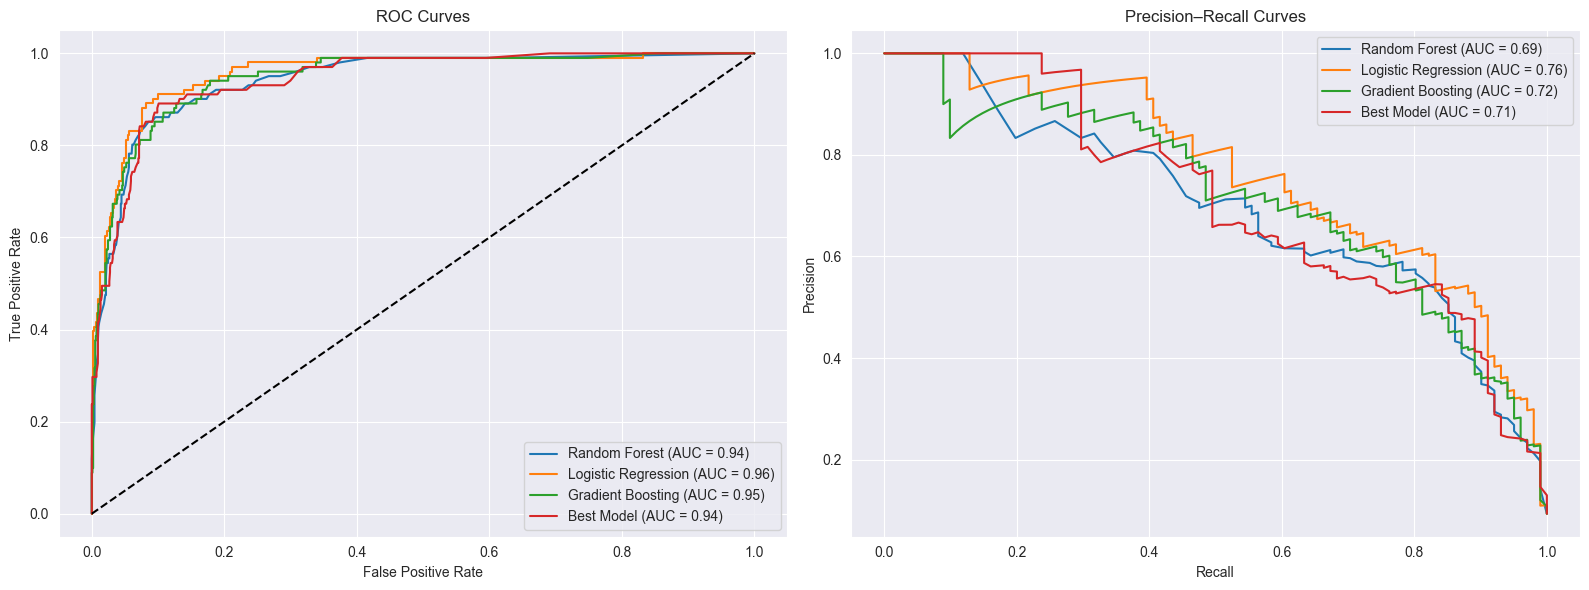

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models = [
    (rf_model, "Random Forest"),
    (lr_model, "Logistic Regression"),
    (gb_model, "Gradient Boosting"),
]

if best_model is not None and best_model not in [m for m, _ in models]:
    models.append((best_model, "Best Model"))

# 1. ROC Curves
for model, name in models:
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title("ROC Curves")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()

# 2. Precision–Recall Curves
for model, name in models:
    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, label=f"{name} (AUC = {pr_auc:.2f})")

axes[1].set_title("Precision–Recall Curves")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()

plt.tight_layout()
plt.show()

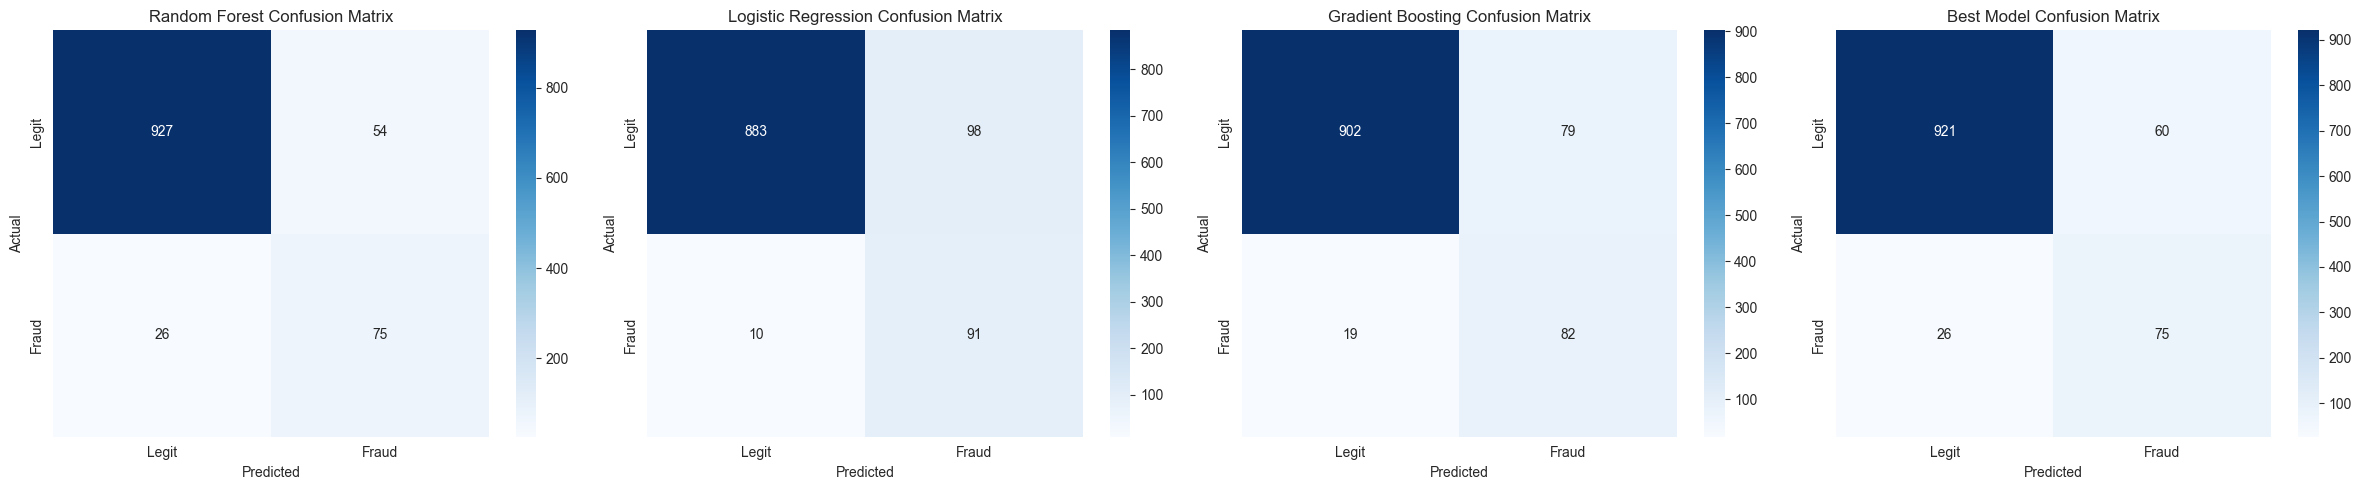

In [4]:
# Confusion matrices
all_models_for_cm = [
    (rf_model, "Random Forest"),
    (lr_model, "Logistic Regression"),
    (gb_model, "Gradient Boosting"),
]

if best_model is not None and best_model not in [m for m, _ in all_models_for_cm]:
    all_models_for_cm.append((best_model, "Best Model"))

fig, axes = plt.subplots(1, len(all_models_for_cm), figsize=(6 * len(all_models_for_cm), 5))

if len(all_models_for_cm) == 1:
    axes = [axes]

for i, (model, name) in enumerate(all_models_for_cm):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"{name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
    axes[i].set_xticklabels(["Legit", "Fraud"])
    axes[i].set_yticklabels(["Legit", "Fraud"])

plt.tight_layout()
plt.show()

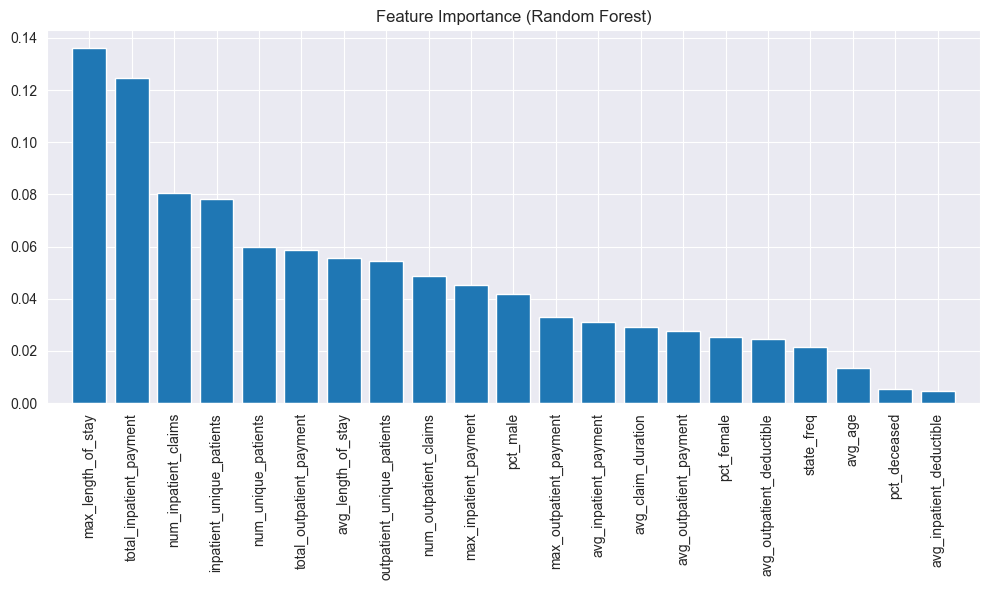

In [5]:
# Feature importance from Random Forest (if available)
if hasattr(rf_model, "feature_importances_"):
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance (Random Forest)")
    plt.bar(range(X_test.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_test.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, X_test.shape[1]])
    plt.tight_layout()
    plt.show()
else:
    print("Random Forest does not expose feature_importances_.")

In [6]:
# Error analysis using Random Forest as primary model
y_pred_rf = rf_model.predict(X_test)

# Build results DataFrame
results_df = pd.DataFrame(X_test, columns=feature_names)
results_df["Actual"] = y_test.values
results_df["Predicted"] = y_pred_rf

# Indices of errors
fp_indices = results_df[(results_df["Actual"] == 0) & (results_df["Predicted"] == 1)].index
fn_indices = results_df[(results_df["Actual"] == 1) & (results_df["Predicted"] == 0)].index

print(f"Found {len(fp_indices)} False Positives and {len(fn_indices)} False Negatives (Random Forest).")

def show_case_studies(indices, title, count=3):
    if len(indices) == 0:
        print(f"\nNo {title} found to analyze.")
        return

    print(f"\n--- Case Studies: {title} ---")
    subset_ids = indices[:count]
    subset_data = pd.DataFrame(X_test, columns=feature_names).loc[subset_ids]

    # Inverse transform to get original scale
    original_values = scaler.inverse_transform(subset_data)
    readable_df = pd.DataFrame(original_values, columns=feature_names)

    display(readable_df.T)

show_case_studies(fp_indices, "False Positives (Legitimate flagged as Fraud)")
show_case_studies(fn_indices, "False Negatives (Fraud missed by Model)")

Found 54 False Positives and 26 False Negatives (Random Forest).

--- Case Studies: False Positives (Legitimate flagged as Fraud) ---


,0,1,2
num_unique_patients,45.000000,73.000000,13.000000
avg_age,80.588235,83.852273,76.785714
pct_male,0.490196,0.363636,0.571429
pct_female,0.509804,0.636364,0.428571
pct_deceased,0.000000,0.000000,0.000000
num_inpatient_claims,51.000000,88.000000,14.000000
inpatient_unique_patients,45.000000,73.000000,13.000000
avg_inpatient_payment,11705.882353,10443.181818,8500.000000
total_inpatient_payment,597000.000000,919000.000000,119000.000000
max_inpatient_payment,57000.000000,50000.000000,38000.000000



--- Case Studies: False Negatives (Fraud missed by Model) ---


,0,1,2
num_unique_patients,12.000000,2.000000,33.000000
avg_age,82.785714,75.000000,81.238095
pct_male,0.428571,1.000000,0.309524
pct_female,0.571429,0.000000,0.690476
pct_deceased,0.000000,0.000000,0.000000
num_inpatient_claims,14.000000,6.000000,42.000000
inpatient_unique_patients,12.000000,2.000000,33.000000
avg_inpatient_payment,9785.714286,6333.333333,9833.333333
total_inpatient_payment,137000.000000,38000.000000,413000.000000
max_inpatient_payment,34000.000000,11000.000000,37000.000000


In [7]:
print("\n--- Financial Impact (Cost-Based Analysis) ---")

# Use the Random Forest-based FN indices from above
fn_data = pd.DataFrame(X_test, columns=feature_names).loc[fn_indices]

# Choose a monetary feature; adjust this name to match your actual column
money_feature_candidates = [
    "Total_Reimbursed",
    "Total_ClaimAmount",
    "total_inpatient_payment"
]

money_feature = None
for cand in money_feature_candidates:
    if cand in feature_names:
        money_feature = cand
        break

if money_feature is None:
    print("No suitable money-related feature found in feature_names; cannot compute cost-based analysis.")
else:
    # Find index of the chosen money feature
    money_idx = feature_names.index(money_feature)

    # Convert back to original scale
    fn_real_scaled = fn_data.values
    fn_real_unscaled = scaler.inverse_transform(fn_real_scaled)
    fn_money_values = fn_real_unscaled[:, money_idx]

    total_missed_fraud_cost = fn_money_values.sum()

    print(f"Using monetary feature: {money_feature}")
    print(f"Total Value of Fraud Missed by Model (False Negatives): ${total_missed_fraud_cost:,.2f}")
    print("Interpretation: This is the estimated amount Medicare loses because the model failed to detect these fraudulent providers.")


--- Financial Impact (Cost-Based Analysis) ---
Using monetary feature: total_inpatient_payment
Total Value of Fraud Missed by Model (False Negatives): $2,474,200.00
Interpretation: This is the estimated amount Medicare loses because the model failed to detect these fraudulent providers.
